# Sunset Day Tracker
(c) Alex Oulton December 2019
* A simple display to graphically show time remaining to sunset
### to be done....
[Dec 31 2019]
* pie chart to show time to next event
* * peek after sunset shows time to next sunrise
* * peek after sunrise shows time to next sunset
* to show 'next event' be it rising or setting need to load today's data plus tomorrow sunrise time
* optional 'now' property on class DayLight for ease of testing 


In [1]:
from datetime import datetime, time, timedelta

class DayLight:
    '''
    everything to do with today sunrise and sunset
    - call methods to calculate their value as of 'now'
    - properties are static as read from CSV file
    '''
    def __init__(self):
        pass
    def daylength(self):
        '''printable string the day's length in hours and minutes '''    
        daylen = self.sunset - self.sunrise
        h,m = divmod((daylen.seconds/60),60) # get minutes and hours in a tuple
        return '{:d}h{:d}m'.format(int(h),int(m)) # format hours and mins nicely.
    
    def timetosunset(self):
        '''printable string of hours and minutes to sunset'''    
        ttss = self.sunset - self.now
        
        # Q? should this be time to next sunrise or sunset ( or even Solar Noon?)

        #if now is after sunset then days is negative
        if ttss.days < 0: 
            return '0h 0m'

        h,m = divmod((ttss.seconds/60),60) # get minutes and hours in a tuple

        return '{:d}h{:d}m'.format(int(h),int(m)) # format hours and mins nicely.
#       if we use timedelta it reports seconds which we need to format 
#       into hours and mins so stick eith divmod appoach for now

    
    def sunelevation(self):
        '''reports sun elevation'''    
        #on mac - shift option 8 for ° degree symbol 
        
        # from rise to solar noon  - report degrees up after solar noon degrees to zero.
        # convert solar noon to datetime
        
        ## ??? is solar mid-day always in the middle of the day?
        ## are there more seconds in the AM than the PM.. for each day?
        
        e = "{:.1f}".format(self.noon_elevation)  + '°'
        
        return(e)

    def sunbearing(self):
        '''reports sun's bearing'''  
        # at solar_noon bearing is always 180° 
        # solar noon is at 1pm-ish during BST
        
        bearing = (self.sunset_bearing - self.sunrise_bearing) * self.progress() 
        
        b = "{:.1f}".format(bearing)  + '°'
        return(b)
    
    def progress(self):
        '''ratio of now vs sunset'''    

        #report zero if outside daylight hours
        if self.now < self.sunrise:
            return 0.0
        if self.now > self.sunset:
            return 0.0

        t1 = self.sunset - self.sunrise
        t2 = self.now - self.sunrise
        ratio = int( t2.seconds) / int(t1.seconds )
        return (ratio)


In [2]:
class InkyPHAT:
    def __init__(self,colour):
        self.WIDTH = 240
        self.HEIGHT = 120
        self.WHITE =  (255,255,255) # 0
        self.BLACK =  (0,0,0) # 1
        self.RED =  2        
        
    def set_border(self,colour):
        pass


In [3]:
def renderscreen(daylight):
    
    # ================= set up screen =======================
    # from inky import InkyPHAT
    inky_display = InkyPHAT("black")
    # for faster B&W set black, the tri colour refresh cycle takes longer
    inky_display.set_border(inky_display.WHITE)

    from PIL import Image, ImageFont, ImageDraw

    # img = Image.new("P", (inky_display.WIDTH, inky_display.HEIGHT))
    img = Image.new("RGB", (inky_display.WIDTH, inky_display.HEIGHT))

    draw = ImageDraw.Draw(img)

    # blank white screen to start
    draw.rectangle([(0,0),(inky_display.WIDTH, inky_display.HEIGHT)],fill=inky_display.WHITE)

    # ================= draw progress bar/circle =======================
    midWidth = inky_display.WIDTH / 2 + 10 # teeny bit to the right of centre
    midHeight = inky_display.HEIGHT / 2 + 10 # and teeny bit lower looks better

    radius1 = 43
    radius2 = 53
    
    # pie chart: zero degrees starting at clockwise 3pm 
    startAngle = 135  # about 8 o'clock
    endAngle = 45     # about 4 o'clock
    # 270 deg between 8 o'clock and 4 o'clock
    nowAngle = (daylight.progress() * 270 + startAngle ) % 360

    # .progress reports value between 0.0 and 1.0
    # nowAngle sweeps a prorated arc from startAngle all the way to endAngle
    # modulo 360 handles the transition at 0 degrees / mid day from 359° to 0°

    # ----------------------------- draw progress bar/circle -------------------------

    Circle1 = (midWidth-radius1, midHeight-radius1, midWidth+radius1, midHeight+radius1)
    Circle2 = (midWidth-radius2, midHeight-radius2, midWidth+radius2, midHeight+radius2)

    draw.arc( Circle2 , startAngle, endAngle, fill = inky_display.BLACK)
    draw.arc( Circle1 , startAngle, endAngle, fill = inky_display.BLACK)

    draw.point([midWidth,midHeight])

#     draw.pieslice( Circle2 ,startAngle, nowAngle, fill = inky_display.BLACK)
#     #draw pie segment to show progress thru day

    draw.pieslice( Circle2 ,nowAngle,nowAngle + 30, fill = inky_display.BLACK)
    #draw short arc 

    draw.ellipse( Circle1, fill = inky_display.WHITE, outline =  inky_display.WHITE)
    
    draw.arc( Circle2 , startAngle, endAngle, fill = inky_display.BLACK)
    draw.arc( Circle1 , startAngle, endAngle, fill = inky_display.BLACK)

    
    # ================= print up fields =======================
    ImageFont.truetype("/Library/Fonts/Arial Unicode.ttf",14)

    fontLabel = ImageFont.truetype("/Library/Fonts/Arial Unicode.ttf",16)
    fontNumber = ImageFont.truetype("/Library/Fonts/Arial Unicode.ttf",18)
    fontBig = ImageFont.truetype("/Library/Fonts/Arial Unicode.ttf",20)

    msg1 = "Sun Rise:"
    msg2 = datetime.strftime(daylight.sunrise,'%H:%M')

    msg3 = "Today:"
    msg4 = daylight.daylength()

    msg5 = "Sun Set:"
    msg6 =  datetime.strftime(daylight.sunset,'%H:%M')

    msg7 = daylight.sunbearing()  
    msg8 = daylight.sunelevation()
    msg9 = daylight.timetosunset()
    msgA = datetime.strftime(daylight.now,'%H:%M') # get time now as a string
    msgB = datetime.strftime(daylight.now,'%b %d') # get time now as a string
    
    # get text box size for each of our fields
    w1, h1 = fontLabel.getsize(msg1)
    w2, h2 = fontNumber.getsize(msg2)
    w3, h3 = fontLabel.getsize(msg3)
    w4, h4 = fontNumber.getsize(msg4)
    w5, h5 = fontLabel.getsize(msg5)
    w6, h6 = fontNumber.getsize(msg6)
    w7, h7 = fontNumber.getsize(msg7)
    w8, h8 = fontNumber.getsize(msg8)
    w9, h9 = fontBig.getsize(msg9)
    wA, hA = fontNumber.getsize(msgA)
    wB, hB = fontNumber.getsize(msgB)

    #calculate screen locations for our msgX fields
    loc1 = (0,0)                             # top left
    loc2 = (0,h1+1)                          # under top left
    loc3 = (0,inky_display.HEIGHT - h3 - h4) # above botton left
    loc4 = (0,inky_display.HEIGHT - h3)      # botton left

    loc5 = (inky_display.WIDTH - w5, 0)      # top right
    loc6 = (inky_display.WIDTH - w6, h5)     # under top right / h5
    loc7 = (midWidth - w7/2, midHeight )     # centered hanging from mid point
    loc8 = (midWidth - w8/2, midHeight + h7 )            # centered below msg7

    loc9 = (midWidth - w9/2, midHeight - h9)  # centred above midpoint 

    locA= (inky_display.WIDTH - wA, inky_display.HEIGHT - hA ) # bottom right
    locB= (inky_display.WIDTH - wB, inky_display.HEIGHT - hB - hA) # stacked above bottom right

    draw.text(loc1, msg1, inky_display.BLACK, fontLabel)
    draw.text(loc2, msg2, inky_display.BLACK, fontNumber)
    draw.text(loc3, msg3, inky_display.BLACK, fontLabel)
    draw.text(loc4, msg4, inky_display.BLACK, fontNumber)
    draw.text(loc5, msg5, inky_display.BLACK, fontLabel)
    draw.text(loc6, msg6, inky_display.BLACK, fontNumber)
    draw.text(loc7, msg7, inky_display.BLACK, fontNumber)
    draw.text(loc8, msg8, inky_display.BLACK, fontNumber)
    draw.text(loc9, msg9, inky_display.BLACK, fontBig)
    draw.text(locA, msgA, inky_display.BLACK, fontNumber)
    draw.text(locB, msgB, inky_display.BLACK, fontNumber)

    #print the graph inline - instead of to inky phat
    %matplotlib inline

    display(img)

In [4]:
def loadToday(today):
    """ read sunrise times and return an instance of DayLight"""
    import csv
    from datetime import datetime, time

    data_file = "sunrise2020.csv"
    file = open(data_file, newline='')
    reader = csv.reader(file)
    header = next(reader) # first line of file
    
    daylight = DayLight()
    
    daylight.load = False
    
    for row in reader:

        date = datetime.strptime(row[0],'%d/%m/%Y')
        if date == today:
            daylight.sunrise = datetime.strptime( row[0] +' '+ row[1],'%d/%m/%Y %H:%M')
            daylight.sunrise_bearing = float(row[2])
            daylight.sunset = datetime.strptime( row[0] +' '+ row[3],'%d/%m/%Y %H:%M')
            daylight.sunset_bearing = float(row[4])
#   ignore         daylight.day_length = datetime.strptime(row[5],'%H:%M:%S')
            daylight.solar_noon = row[6]
            daylight.noon_elevation = float(row[7])
            daylight.load = True
            break
        else:
            pass

    return(daylight)

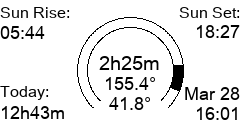

In [10]:

#Load today's time from data file. 
today = datetime.strftime(datetime.now(),'%d/%m/%Y')
today = datetime.strptime(today,'%d/%m/%Y')
today


# afterSunset = datetime.strptime('28/12/2019 16:05','%d/%m/%Y %H:%M')
beforeSunRise =  datetime.strptime('31/12/2019 17:00','%d/%m/%Y %H:%M')

daylight = loadToday(today)
daylight.now = datetime.now()

renderscreen(daylight)

In [6]:
print(daylight.sunrise)
print(daylight.sunset)

tdiff1 = daylight.sunset - daylight.sunrise
tdiff2 = daylight.now - daylight.sunrise
print(tdiff2/tdiff1)
print(tdiff1.seconds)
print(tdiff2.seconds)

print(daylight.sunrise_bearing)
print(daylight.sunset_bearing)

print(daylight.solar_noon)
print(daylight.noon_elevation)



2020-03-28 05:44:00
2020-03-28 18:27:00
0.7753791232197467
45780
35496
84.0
276.0
12:05
41.8


In [7]:
print(daylight.daylength() )
print(daylight.timetosunset() )
print(daylight.sunelevation() )
print(daylight.sunbearing() )
print(daylight.progress() )

12h43m
2h51m
41.8°
148.9°
0.7753604193971166


In [8]:
daylight.now
# fourPM = datetime.strptime('28/12/2019 16:00','%d/%m/%Y %H:%M')
# fivePM = datetime.strptime('28/12/2019 17:00','%d/%m/%Y %H:%M')

# xx = fourPM - fivePM
# yy = fivePM - fourPM

datetime.datetime(2020, 3, 28, 15, 35, 36, 856261)

In [9]:
print(xx.days)

print(yy.days)
print(yy.seconds)

NameError: name 'xx' is not defined

In [ ]:
%j: Returns the number of the day in the year, from 001 to 366.
%W: Returns the week number of the year, from 00 to 53, with Monday being counted as the first day of the week.

In [ ]:
# print("{:.2f}".format(3.1415926));

bearing = (100.0 -50.0) * 0.75
print (bearing)
        

b = "{:.1f}".format(bearing)  + '°'

print(b)


In [6]:
type(daylight.sunelevation())

float